In [6]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from einops import rearrange, repeat
from parallelattention import TimeSeriesClassifier, FullAttention
from sklearn.model_selection import train_test_split, StratifiedKFold
from utils_window import TimeSeriesScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from torchsummary import summary
torch.manual_seed(0) #set seed for reproducibility
np.random.seed(0)

In [7]:
data = np.load('mimic4_acute_resp_failure_vsdata_ldcbf_4209_048_19_btf.npz')
data_all, label = data['arr_0'], data['arr_1'].reshape(-1,1)
data_scaler = TimeSeriesScaler()
data_x = data_scaler.fit_transform(data_all)

In [8]:
# print(torch.from_numpy(data_all).shape, torch.from_numpy(label).shape)

X = torch.from_numpy(data_x)
y = torch.from_numpy(label.reshape(-1,1))
# y = torch.from_numpy(label)


train_x, test_x, train_y, test_y= train_test_split(X, y,test_size=0.2, random_state=42, stratify=y)


# Data Loaders
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(test_x, test_y)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [9]:

# Hyperparameters
num_features = 19  # Adjust this to the number of features in your dataset
num_classes = 1   # Adjust this to the number of classes in your dataset
seg_len = 48       # Segment number or 
#time steps seg_num = 48
# factor = 8         # Factor for the router
d_model = 16       # Model dimension
n_heads = 8       # Number of attention heads

# Instantiate model
model = TimeSeriesClassifier(num_features, num_classes, seg_len, n_heads)
# Print the summary

# print(model.summary())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


print('Running on',device)

model.to(device) 

# summary(model, input_size=(seg_len, num_features))


# Loss and Optimizer
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### implement LR reducer, increase training accuracy


# Training Loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    # Initialize lists to store predictions and labels for each batch
    train_preds = []
    train_labels = []
    train_losses = []

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.float()  # Ensure batch_X is in float32 format

        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        # outputs = model(batch_X).squeeze()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.float())
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        preds = (probs >= 0.5).float()  # Threshold probabilities to generate predictions

        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(batch_y.cpu().numpy())

        # print(train_preds[0].shape, train_labels[0].shape)
        # break
    # break

    # Train metrics

    train_accuracy = accuracy_score(train_labels, train_preds)
    # train_precision = precision_score(train_labels, train_preds, average='weighted')
    # train_recall = recall_score(train_labels, train_preds, average='weighted')
    train_f1 = f1_score(train_labels, train_preds, average='weighted')
    train_mcc= matthews_corrcoef(train_labels, train_preds)
    
    # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    # Validation step
    model.eval()  # Set model to evaluation mode
    val_preds = []
    val_labels = []
    val_losses = []

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.float()
            batch_y = batch_y.float()

            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            # outputs = model(batch_X).squeeze()
            outputs = model(batch_X)

            val_loss = criterion(outputs, batch_y)
            val_losses.append(val_loss.item()) 


            # print(outputs)
            # Apply sigmoid and threshold at 0.5 for predictions
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch_y.cpu().numpy())


    # Validation metrics
    val_accuracy = accuracy_score(val_labels, val_preds)
    # val_precision = precision_score(val_labels, val_preds, average='weighted')
    # val_recall = recall_score(val_labels, val_preds, average='weighted')
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    val_mcc= matthews_corrcoef(val_labels, val_preds)


    print(f"Epoch {epoch+1}/{num_epochs}, "
    	  f"Train Loss: {np.mean(train_losses):.4f}, Train Accuracy: {train_accuracy:.4f}, Train F1 Score: {train_f1:.4f}, Train MCC: {train_mcc:.4f}, "
          f"Val Loss:   {np.mean(val_losses):.4f}, Val Accuracy: {val_accuracy:.4f}, Val F1 Score: {val_f1:.4f}, Val MCC: {val_mcc:.4f}")


Running on cuda
Epoch 1/50, Train Loss: 0.5762, Train Accuracy: 0.7083, Train F1 Score: 0.6838, Train MCC: 0.2137, Val Loss:   0.5726, Val Accuracy: 0.7316, Val F1 Score: 0.6706, Val MCC: 0.2296
Epoch 2/50, Train Loss: 0.5515, Train Accuracy: 0.7348, Train F1 Score: 0.7104, Train MCC: 0.2856, Val Loss:   0.5332, Val Accuracy: 0.7458, Val F1 Score: 0.7172, Val MCC: 0.3099
Epoch 3/50, Train Loss: 0.5312, Train Accuracy: 0.7410, Train F1 Score: 0.7181, Train MCC: 0.3055, Val Loss:   0.5372, Val Accuracy: 0.7328, Val F1 Score: 0.7161, Val MCC: 0.2975
Epoch 4/50, Train Loss: 0.5146, Train Accuracy: 0.7618, Train F1 Score: 0.7421, Train MCC: 0.3679, Val Loss:   0.5758, Val Accuracy: 0.7399, Val F1 Score: 0.7151, Val MCC: 0.2994
Epoch 5/50, Train Loss: 0.5015, Train Accuracy: 0.7624, Train F1 Score: 0.7465, Train MCC: 0.3764, Val Loss:   0.5592, Val Accuracy: 0.7470, Val F1 Score: 0.7236, Val MCC: 0.3215
Epoch 6/50, Train Loss: 0.4897, Train Accuracy: 0.7576, Train F1 Score: 0.7413, Train MCC

In [10]:
model

TimeSeriesClassifier(
  (time_attention): TimeAttentionLayer(
    (time_attention): AttentionLayer(
      (inner_attention): FullAttention(
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (query_projection): Linear(in_features=19, out_features=128, bias=True)
      (key_projection): Linear(in_features=19, out_features=128, bias=True)
      (value_projection): Linear(in_features=19, out_features=128, bias=True)
      (out_projection): Linear(in_features=128, out_features=19, bias=True)
    )
    (dropout): Dropout(p=0.5, inplace=False)
    (norm1): LayerNorm((19,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((19,), eps=1e-05, elementwise_affine=True)
    (MLP1): Sequential(
      (0): Linear(in_features=19, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=19, bias=True)
    )
  )
  (feat_attention): FeatAttentionLayer(
    (dim_attention): AttentionLayer(
      (inner_attention): FullAttention(
 

In [11]:
def extract_attention_weights(model):
    attention_weights = []
    for layer in model.children():
        if isinstance(layer, FullAttention):
            attention_weights.append(layer.attention_weights)
        else:
            attention_weights.extend(extract_attention_weights(layer))
    return attention_weights

In [12]:
# Run a forward pass
temp_test_x = test_x.to(device).float()

output_fp = model(temp_test_x)

In [13]:
temp_test_x.shape, output_fp.shape

(torch.Size([842, 48, 19]), torch.Size([842, 1]))

In [14]:
# Extract attention weights
attention_weights_list = extract_attention_weights(model)

In [15]:
len(attention_weights_list)

2

In [16]:
time_attention = attention_weights_list[0]
feat_attention = attention_weights_list[1]

In [17]:
time_attention.shape, feat_attention.shape

((842, 8, 48, 48), (842, 8, 19, 19))

In [18]:
# attention_weights_list = feat_attention

In [19]:
# attention_weights_list.shape

In [20]:
import matplotlib.pyplot as plt

In [21]:
sample = 10
sample_time = time_attention[sample,:,:,:]
sample_feat = feat_attention[sample,:,:,:]

In [22]:
sample_time.shape, sample_feat.shape

((8, 48, 48), (8, 19, 19))

In [23]:
# # plt.figure()
# fig, ax = plt.subplots(figsize=(8,8))
# cax = ax.imshow(get_att,cmap=plt.cm.Reds, vmin=0, vmax=1)
# cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
# plt.show()

In [24]:
# ### some trial
# # images = [np.random.random((64, 64)) for _ in range(32)]

# hm_list = [samp_sp[i,:,:] for i in range(32)]
# hm_min=np.min(samp_sp)
# hm_max=np.max(samp_sp)

# print('sample min:', hm_min,'     sample max:',hm_max)
# fig, axs = plt.subplots(4, 8, figsize=(20, 10), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})  # Set appropriate figsize
# # Flatten the axis array and iterate over it and the images simultaneously
# for img, ax in zip(hm_list, axs.flatten()):
#     ax.imshow(img, cmap=plt.cm.Reds, vmin=hm_min, vmax=hm_max)  # You can set your own colormap
#     ax.axis('off')  # Optional: turn off the axis for each subplot

# # Show the entire plot with all subplots
# plt.show()

In [25]:
# ####### average across all attention heads
# # plt.figure()
# fig, ax = plt.subplots(figsize=(8,8))
# cax = ax.imshow(np.mean(samp_sp, axis=0),cmap=plt.cm.Reds, 
#                 # vmin=hm_min, vmax=hm_max
#                )
# cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
# plt.show()

In [26]:
sample_time.shape, sample_feat.shape

((8, 48, 48), (8, 19, 19))

In [27]:
##lets take mean across the attention axis

In [28]:
st_mean = np.mean(sample_time,axis=0)
sf_mean = np.mean(sample_feat,axis=0)

In [29]:
# Calculate mean attention across features for each time point
time_mean_attention = st_mean.mean(axis=0, keepdims=True)  # Resulting shape: (48, 1)

# Calculate mean attention across time points for each feature
feature_mean_attention = sf_mean.mean(axis=0, keepdims=True)  # Resulting shape: (19, 1)

# Calculate outer product of time_mean_attention and feature_mean_attention
combined_attention = np.dot(feature_mean_attention.T, time_mean_attention)  # Resulting shape: (19, 48)

In [30]:
# explicit function to normalize array
def normalize(arr, t_min=0, t_max=1):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = np.max(arr) - np.min(arr)
    for i in arr:
        temp = (((i - np.min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

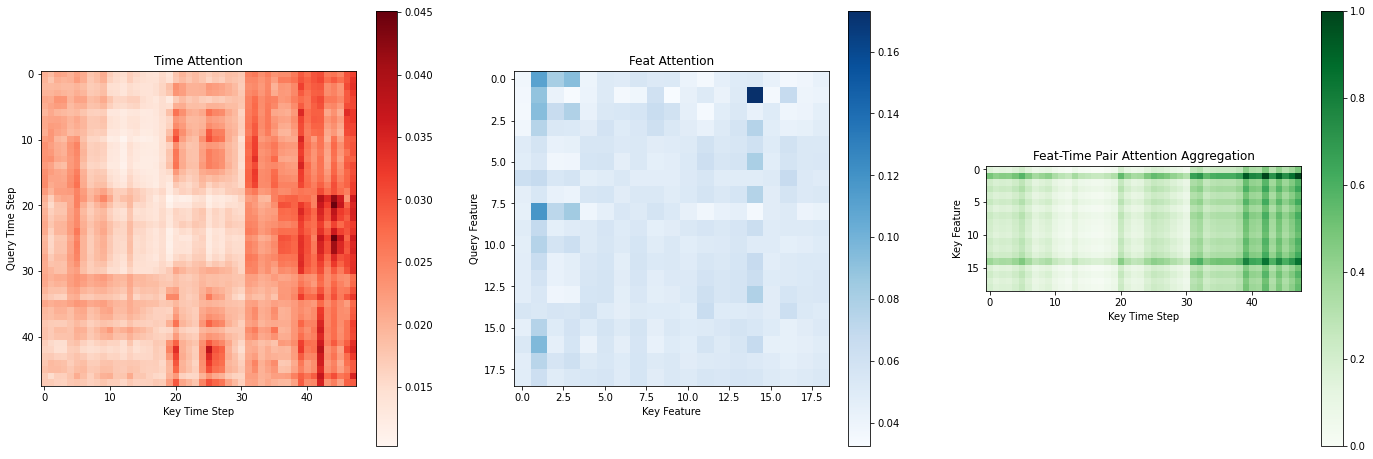

In [31]:
####### average across all attention heads
# plt.figure()
fig, ax = plt.subplots(1,3,figsize=(24,8))
cax0 = ax[0].imshow(np.mean(sample_time, axis=0),cmap=plt.cm.Reds, 
                # vmin=hm_min, vmax=hm_max
               )
cbar0 = fig.colorbar(cax0, ax=ax[0], orientation='vertical')
ax[0].set_xlabel('Key Time Step')
ax[0].set_ylabel('Query Time Step')
ax[0].set_title('Time Attention')


cax1 = ax[1].imshow(np.mean(sample_feat, axis=0),cmap=plt.cm.Blues, 
                # vmin=hm_min, vmax=hm_max
               )
cbar1 = fig.colorbar(cax1, ax=ax[1], orientation='vertical')
ax[1].set_xlabel('Key Feature')
ax[1].set_ylabel('Query Feature')
ax[1].set_title('Feat Attention')

cax2 = ax[2].imshow(normalize(combined_attention),cmap=plt.cm.Greens)
cbar2 = fig.colorbar(cax2, ax=ax[2], orientation='vertical')
ax[2].set_xlabel('Key Time Step')
ax[2].set_ylabel('Key Feature')
ax[2].set_title('Feat-Time Pair Attention Aggregation')

plt.show()

## we need some kind of ablation experiment here to make sense of the feature time point aggegation

## to get feat_time scores: one way is to get mean for both matrices across each key time step and then take a dot product.
## another is that we use the input and multiply the 3 matrices.

In [187]:
### use the input



In [188]:
########### or get the input matrix and do 3 way product

time_att = 48*48, feat_att= 19*19, data= 48x19

att_agg = time_att x data x feat_att

In [189]:
inp = test_x[sample,:,:]

In [190]:
sf_mean.shape, inp.numpy().shape, st_mean.shape

((19, 19), (48, 19), (48, 48))

In [191]:
# Apply time attention

# Apply feature attention
input_att_aggregation = np.dot(sf_mean, np.dot(inp.T, st_mean))

In [194]:
input_att_aggregation.shape ## t

## this approach doesn;t make any sense

In [195]:
# ####### average across all attention heads
# # plt.figure()
# fig, ax = plt.subplots(1,3,figsize=(24,8))
# cax0 = ax[0].imshow(np.mean(sample_time, axis=0),cmap=plt.cm.Reds, 
#                 # vmin=hm_min, vmax=hm_max
#                )
# cbar0 = fig.colorbar(cax0, ax=ax[0], orientation='vertical')
# ax[0].set_xlabel('Key Time Step')
# ax[0].set_ylabel('Query Time Step')
# ax[0].set_title('Time Attention')


# cax1 = ax[1].imshow(np.mean(sample_feat, axis=0),cmap=plt.cm.Blues, 
#                 # vmin=hm_min, vmax=hm_max
#                )
# cbar1 = fig.colorbar(cax1, ax=ax[1], orientation='vertical')
# ax[1].set_xlabel('Key Feature')
# ax[1].set_ylabel('Query Feature')
# ax[1].set_title('Feat Attention')

# cax2 = ax[2].imshow(normalize(input_att_aggregation),cmap=plt.cm.Greens, norm=norm)
# cbar2 = fig.colorbar(cax2, ax=ax[2], orientation='vertical')
# ax[2].set_xlabel('Key Time Step')
# ax[2].set_ylabel('Key Feature')
# ax[2].set_title('Feat-Time Pair Attention Aggregation')

# plt.show()

## TODO 

### implement model saving here
### run windowSHAP with pytorch
